## Disaster or Not Tweet Analysis Using BERT pre-trained With PyTorch

References:  

Mehdi Mashayekhi:  
https://github.com/mehdimashayekhi  
Transfer-Learning-in-Natural-Language-Processing  
  
https://www.kaggle.com/code/akshat0007/bert-for-sequence-classification  
  
https://mccormickml.com/2019/07/22/BERT-fine-tuning/  

In [30]:
!nvidia-smi

Thu Dec 26 18:20:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   27C    P0             25W /   70W |     867MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [31]:
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler,SequentialSampler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel, AutoConfig

import pandas as pd
import numpy as np
import nltk
import re
import time
import datetime
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Data preprocessing

In [33]:
df = pd.read_csv('data/train.csv')

In [34]:
df.shape

(7613, 5)

In [35]:
df.sample(5)

,id,keyword,location,text,target
3897,5541,flattened,"Northampton, MA",@JimMozel puck=flattened ball lol,0
872,1263,blood,NaN,Man . somebody gotta stop Sbee dude too fuckin...,0
2122,3049,death,?s????ss? a?????,Ari's hints and snippets will be the death of me.,0
6334,9055,structural%20failure,NaN,@SirTitan45 Mega mood swing on a 24 hr schedu...,0
4423,6294,hostage,NaN,I always tell my mom to bring me food or I wil...,0


In [36]:
def pos_oversampling(df):
    add_pos = 4342 - 3271
    pos_df = df[df["target"] == 1]
    neg_df = df[df["target"] == 0]
    pos_df.reset_index(inplace=True)
    pos_add_indices = np.random.choice(pos_df.index, add_pos, replace=False)
    pos_add_df = pos_df.iloc[pos_add_indices]
    pos_oversampled = pd.concat([pos_df, pos_add_df], ignore_index=True)
    balanced_df = pd.concat([neg_df, pos_oversampled], ignore_index=True)
    return balanced_df

In [37]:
# Due to the imbalance of the dataset, oversample the positive tweets
balanced_df = pos_oversampling(df)

In [38]:
# replace empty cells with a strin "NA"
balanced_df.fillna('NA', inplace=True)

/tmp/ipykernel_1351/1728943000.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  balanced_df.fillna('NA', inplace=True)


In [39]:
# Concatenate keyword, location, and text and name the new column as tweet.
balanced_df['tweet'] = balanced_df['keyword'] + ' ' + balanced_df['location'] + ' ' + balanced_df['text']

### Create sentence and label lists

To use BERT, We need to add special tokens at the beginning and end of each sentence for BERT to work properly

In [40]:
sentences = balanced_df.text.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = balanced_df.target.values

## Inputs

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenize the first sentence:
['[CLS]', 'what', "'", 's', 'up', 'man', '?', '[SEP]']


In [42]:
# Set the maximum sequence length. The longest sequence in our training set is 28.
MAX_LEN = 28

In [43]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [44]:
print(input_ids[0])

[101, 2054, 1005, 1055, 2039, 2158, 1029, 102]


In [45]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [46]:
print(input_ids[0])

[ 101 2054 1005 1055 2039 2158 1029  102    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


Create the attention masks 

In [47]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [48]:
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Use train_test_split to split our data into train and validation sets for training

In [49]:
tr_inputs, test_inputs, tr_labels, test_labels = train_test_split(input_ids, labels, test_size=0.20, random_state=38)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(tr_inputs, tr_labels, test_size=0.25, random_state=28)
tr_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.20, random_state=38)
train_masks, validation_masks, _, _ = train_test_split(tr_masks, tr_inputs, test_size=0.25, random_state=28)

In [50]:
# Convert all of our data into torch tensors, the required type for our pytorch model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [51]:
print(train_inputs.shape)

torch.Size([5210, 28])


Select a batch size for training. 

For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32. Create an iterator of our data with torch DataLoader. 

In [52]:
batch_size = 16

# Training
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


### Model set up

In [53]:
## Hyper-parameters

epochs = 20
lr = 2e-5
eps = 1e-8
num_labels = 2
random_seed = 38

#### Hyperparameter change in BERT pre-trained model

configuration lets us to modify the pre-trained BERT hyperparameters as follows.

In [54]:
configuration = AutoConfig.from_pretrained('bert-base-uncased')

In [55]:
configuration.hidden_dropout_prob = 0.4
configuration.attention_probs_dropout_prob = 0.4

In [56]:
model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path = 'bert-base-uncased', 
config = configuration)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.4, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [57]:
def flat_accuracy(preds, labels):
    '''calculate the accuracy of our predictions vs labels
    '''
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [58]:
optimizer = AdamW(model.parameters(),
                  lr = lr,
                  eps = eps)

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader) * epochs)

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

training_loss_acc = {}
validation_loss_acc = {}
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    # Reset the total loss for this epoch.
    total_train_loss = 0
    total_train_accuracy = 0

    # Put the model into training mode. 
    model.train()
    
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear any previously calculated gradients before performing a backward pass. 
        model.zero_grad()        

        # Perform a forward pass 
        outputs = model(b_input_ids,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss = outputs.loss
        logits = outputs.logits

        # Accumulate the training loss over all of the batches
        total_train_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_train_accuracy += flat_accuracy(logits, label_ids)
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)
    # Report the final accuracy for this validation run.
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    training_loss_acc[epoch_i] = [avg_train_loss, avg_train_accuracy]

    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

            loss = outputs.loss
            logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_loss_acc[epoch_i] = [avg_val_loss, avg_val_accuracy]

    print('Training - Loss: {:.15f} | Accuracy: {:.15f}'.format(avg_train_loss, avg_train_accuracy))
    print('Validation - Loss: {:.15f} | Accuracy: {:.15f}'.format(avg_val_loss, avg_val_accuracy))

print("")
print("Training complete!")

/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 20 ========
Training - Loss: 0.603283559617821 | Accuracy: 0.673427914110429
Validation - Loss: 0.511019053399016 | Accuracy: 0.768858307849134
======== Epoch 2 / 20 ========
Training - Loss: 0.498659485185439 | Accuracy: 0.778604294478528
Validation - Loss: 0.617016085175746 | Accuracy: 0.749808868501529
======== Epoch 3 / 20 ========
Training - Loss: 0.451217008606057 | Accuracy: 0.799693251533742
Validation - Loss: 0.590527715862071 | Accuracy: 0.767010703363914
======== Epoch 4 / 20 ========
Training - Loss: 0.411420871509365 | Accuracy: 0.823351226993865
Validation - Loss: 0.526994136085204 | Accuracy: 0.794979612640163
======== Epoch 5 / 20 ========
Training - Loss: 0.390592470925096 | Accuracy: 0.835007668711656
Validation - Loss: 0.646999199729447 | Accuracy: 0.773764016309888
======== Epoch 6 / 20 ========
Training - Loss: 0.371599590280122 | Accuracy: 0.846319018404908
Validation - Loss: 0.590402379221872 | Accuracy: 0.764143730886850
======== Epoch 7 / 20 

### Model evaluation

In [59]:
training_loss_acc

{0: [0.6032835596178207, 0.6734279141104295],
 1: [0.49865948518543884, 0.7786042944785275],
 2: [0.4512170086060565, 0.7996932515337423],
 3: [0.4114208715093648, 0.8233512269938651],
 4: [0.39059247092509564, 0.8350076687116563],
 5: [0.3715995902801218, 0.8463190184049079],
 6: [0.3401081856637279, 0.8598159509202454],
 7: [0.3305071988171595, 0.8710506134969325],
 8: [0.30100362423373145, 0.8846625766871165],
 9: [0.2969182069567632, 0.8820935582822086],
 10: [0.2794180920496126, 0.8952070552147239],
 11: [0.27313454825134, 0.8975076687116563],
 12: [0.26039367441110817, 0.906441717791411],
 13: [0.2509711862433176, 0.906441717791411],
 14: [0.23827918299810927, 0.9132285276073618],
 15: [0.23964383958787458, 0.9124616564417177],
 16: [0.23542774618928966, 0.9172546012269938],
 17: [0.2221783271825021, 0.9236963190184049],
 18: [0.22075838865026648, 0.9231978527607362],
 19: [0.21685177068357453, 0.9251150306748466]}

In [60]:
validation_loss_acc

{0: [0.511019053399016, 0.7688583078491336],
 1: [0.6170160851757461, 0.7498088685015291],
 2: [0.5905277158620708, 0.7670107033639144],
 3: [0.5269941360852041, 0.794979612640163],
 4: [0.646999199729447, 0.7737640163098878],
 5: [0.5904023792218724, 0.7641437308868502],
 6: [0.6044549151844935, 0.7921126401630988],
 7: [0.6448494000104043, 0.7595565749235474],
 8: [0.6942929194197742, 0.7704510703363915],
 9: [0.7764389426233845, 0.7539500509683996],
 10: [0.7603788274007106, 0.7794979612640163],
 11: [0.6147219183077233, 0.8064475025484199],
 12: [0.6626946188919588, 0.7807721712538227],
 13: [0.79905912304861, 0.748789500509684],
 14: [0.8037347930885099, 0.77618501529052],
 15: [0.7752836162326943, 0.7903924566768603],
 16: [0.8174640953096501, 0.775611620795107],
 17: [0.9087770924894908, 0.7516564729867482],
 18: [0.8051043264567852, 0.7768858307849134],
 19: [0.835821398508248, 0.7734454638124363]}

In [61]:
# epoch vs training accuracy
epoch_tr_acc = [v[1] for k, v in training_loss_acc.items()]

In [62]:
# epoch vs validation accuracy
epoch_vl_acc = [v[1] for k, v in validation_loss_acc.items()]

In [63]:
# epoch vs training loss
epoch_tr_loss = [v[0] for k, v in training_loss_acc.items()]

In [64]:
# epoch vs validation loss
epoch_vl_loss = [v[0] for k, v in validation_loss_acc.items()]

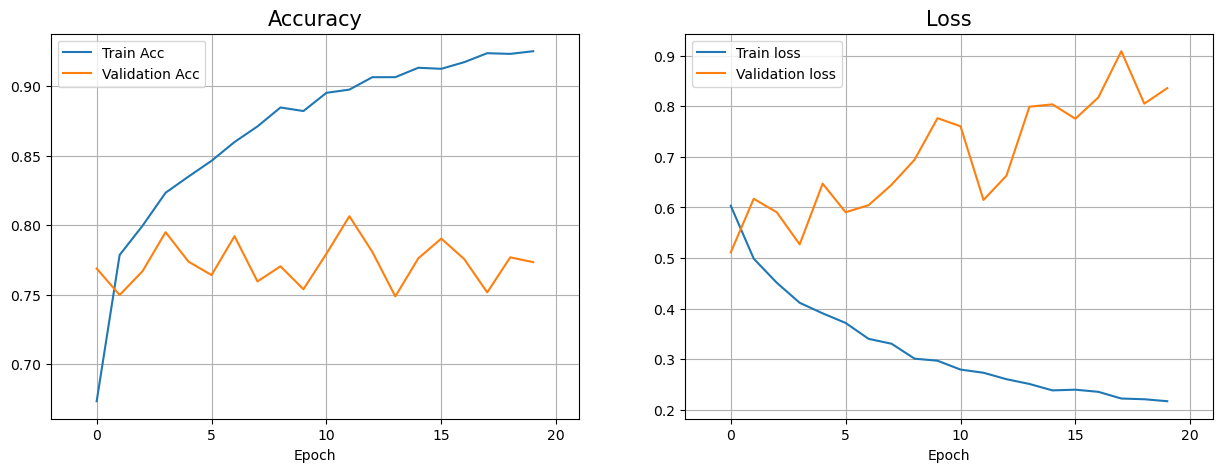

In [65]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy", fontsize=15)
plt.xlabel('Epoch')
plt.xlim(-2, 21)
plt.legend()
plt.grid()
   
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss", fontsize=15)
plt.xlabel('Epoch')
plt.xlim(-2, 21)
plt.legend()
plt.grid()

plt.show()